# Assigning satellite data to geo-locations

## Example: Tracking the International Space Station with Dask

In this notebook we will use two APIs:

1. [Google Maps Geocoder](https://developers.google.com/maps/documentation/geocoding/overview)
2. [Open Notify API for ISS location](http://api.open-notify.org/)

We will use them to track ISS location and next transit time with respect to a list of cities. To create our charts and parallelise data intelligently, we will use Dask, specifically [Dask Delayed](../performance/dask.html#Dask-Delayed).

### 1. Imports

In [1]:
import requests
import logging
import sys
import numpy as np
from time import sleep
from datetime import datetime
from math import radians
from dask import delayed
from operator import itemgetter
from sklearn.neighbors import DistanceMetric

### 2. Logger

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 3. latitude and longitude pairs from a list of cities

see also [Location APIs](https://locationiq.com/)

In [3]:
def get_lat_long(address):
    resp = requests.get(
        'https://eu1.locationiq.org/v1/search.php',
        params={'key': '92e7ba84cf3465',
                'q': address,
                'format': 'json'}
    )
    if resp.status_code != 200:
        print('There was a problem with your request!')
        print(resp.content)
        return
    data = resp.json()[0]
    return {
        'name': data.get('display_name'),
        'lat': float(data.get('lat')),
        'long': float(data.get('lon')),
    }

In [4]:
get_lat_long('Berlin, Germany')

{'name': 'Berlin, 10117, Germany', 'lat': 52.5170365, 'long': 13.3888599}

In [5]:
locations = []
for city in ['Seattle, Washington',
             'Miami, Florida', 
             'Berlin, Germany',
             'Singapore', 
             'Wellington, New Zealand',
             'Beirut, Lebanon',
             'Beijing, China',
             'Nairobi, Kenya',
             'Cape Town, South Africa',
             'Buenos Aires, Argentina']:
    locations.append(get_lat_long(city))
    sleep(2)

In [6]:
locations

[{'name': 'Seattle, King County, Washington, USA',
  'lat': 47.6038321,
  'long': -122.3300624},
 {'name': 'Miami, Miami-Dade County, Florida, USA',
  'lat': 25.7741728,
  'long': -80.19362},
 {'name': 'Berlin, 10117, Germany', 'lat': 52.5170365, 'long': 13.3888599},
 {'name': 'Singapore', 'lat': 1.357107, 'long': 103.8194992},
 {'name': 'Wellington, Wellington City, Wellington, 6011, New Zealand',
  'lat': -41.2887953,
  'long': 174.7772114},
 {'name': 'Beirut, Beirut Governorate, Lebanon',
  'lat': 33.8959203,
  'long': 35.47843},
 {'name': 'Beijing, Dongcheng District, Beijing, 100010, China',
  'lat': 39.906217,
  'long': 116.3912757},
 {'name': 'Nairobi, Kenya', 'lat': -1.2832533, 'long': 36.8172449},
 {'name': 'Cape Town, City of Cape Town, Western Cape, 8001, South Africa',
  'lat': -33.928992,
  'long': 18.417396},
 {'name': 'Autonomous City of Buenos Aires, Comuna 6, Autonomous City of Buenos Aires, Argentina',
  'lat': -34.6075682,
  'long': -58.4370894}]

## 4. Retrieve ISS data and determine transit times of cities

In [7]:
def get_spaceship_location():
    resp = requests.get('http://api.open-notify.org/iss-now.json')
    location = resp.json()['iss_position']
    return {'lat': float(location.get('latitude')),
            'long': float(location.get('longitude'))}

In [8]:
def great_circle_dist(lon1, lat1, lon2, lat2):
    dist = DistanceMetric.get_metric('haversine')
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    X = [[lat1, lon1], [lat2, lon2]]
    kms = 6367
    return (kms * dist.pairwise(X)).max()

In [9]:
def iss_dist_from_loc(issloc, loc):
    distance = great_circle_dist(issloc.get('long'), 
                                 issloc.get('lat'), 
                                 loc.get('long'), loc.get('lat'))
    logging.info('ISS is ~%dkm from %s', int(distance), loc.get('name'))
    return distance

In [10]:
def iss_pass_near_loc(loc):
    resp = requests.get('http://api.open-notify.org/iss-pass.json',
                        params={'lat': loc.get('lat'), 
                                'lon': loc.get('long')})
    data = resp.json().get('response')[0]
    td = datetime.fromtimestamp(data.get('risetime')) - datetime.now()
    m, s = divmod(int(td.total_seconds()), 60)
    h, m = divmod(m, 60)
    logging.info('ISS will pass near %s in %02d:%02d:%02d',loc.get('name'), h, m, s)
    return td.total_seconds()

In [11]:
iss_dist_from_loc(get_spaceship_location(), locations[2])

INFO:root:ISS is ~12639km from Berlin, 10117, Germany


12639.759939298825

In [12]:
iss_pass_near_loc(locations[2])

INFO:root:ISS will pass near Berlin, 10117, Germany in 00:25:14


1514.253889

## 5. Creating a `delayed` pipeline

In [13]:
output = []

for loc in locations:
    issloc = delayed(get_spaceship_location)()
    dist = delayed(iss_dist_from_loc)(issloc, loc)
    output.append((loc.get('name'), dist))

closest = delayed(lambda x: sorted(x, 
                                   key=itemgetter(1))[0])(output)

In [14]:
closest

Delayed('lambda-5ab5a78f-cb72-4168-bce1-f9983fdb8a2e')

## 6. Show DAG

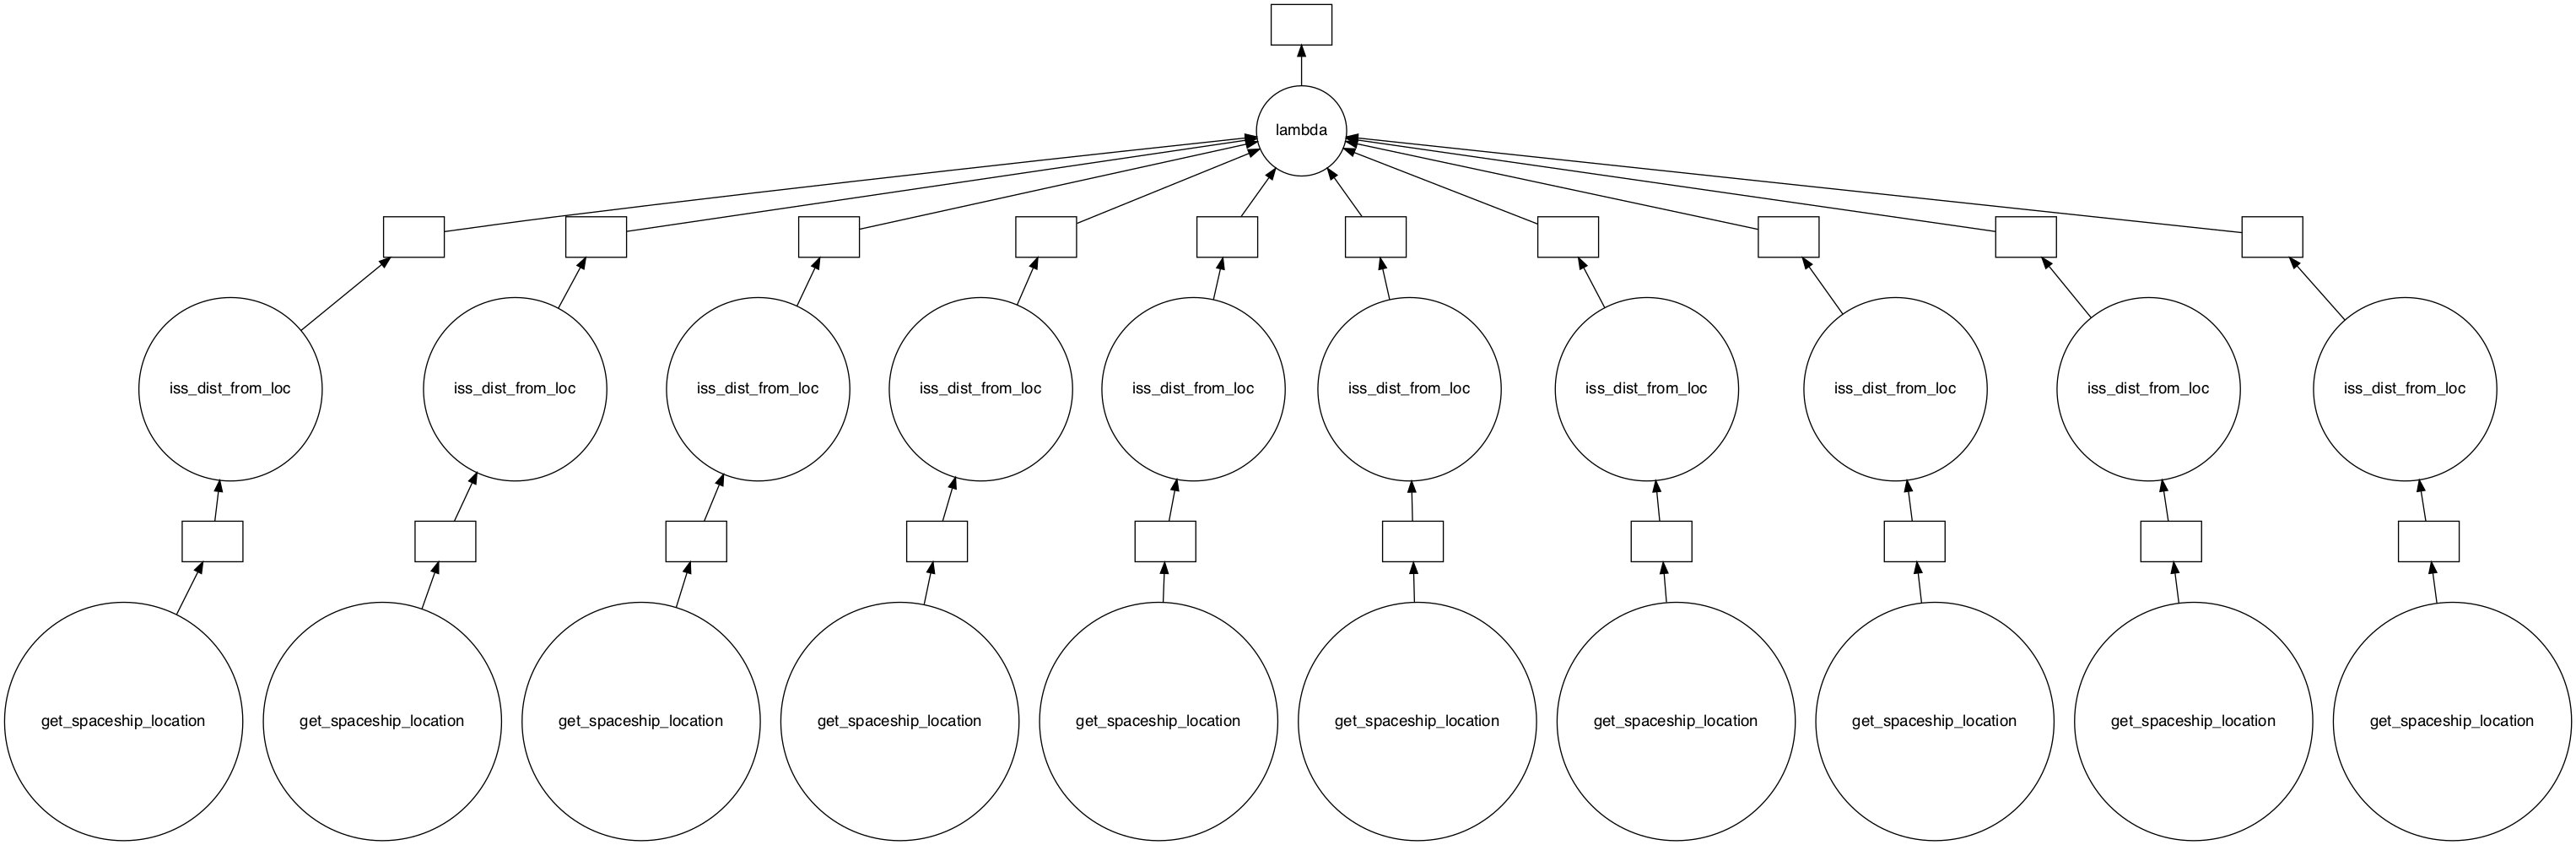

In [15]:
closest.visualize()

## 7. `compute()`

In [16]:
closest.compute()

INFO:root:ISS is ~4685km from Miami, Miami-Dade County, Florida, USA
INFO:root:ISS is ~15205km from Beirut, Beirut Governorate, Lebanon
INFO:root:ISS is ~5919km from Seattle, King County, Washington, USA
INFO:root:ISS is ~6279km from Autonomous City of Buenos Aires, Comuna 6, Autonomous City of Buenos Aires, Argentina
INFO:root:ISS is ~12625km from Berlin, 10117, Germany
INFO:root:ISS is ~13137km from Cape Town, City of Cape Town, Western Cape, 8001, South Africa
INFO:root:ISS is ~16194km from Singapore
INFO:root:ISS is ~16298km from Nairobi, Kenya
INFO:root:ISS is ~13905km from Beijing, Dongcheng District, Beijing, 100010, China
INFO:root:ISS is ~8405km from Wellington, Wellington City, Wellington, 6011, New Zealand


('Miami, Miami-Dade County, Florida, USA', 4685.887400314564)